# Mini-project CSIC5011 -- Topological and Geometric Data Reduction and Visualization
## Team: José Vinícius de Miranda Cardoso, Yixin Men, Shunkang Zhang
## Topic: Learning Stock Networks with Robust PCA

Let's start by loading packages to handle financial data (`xts` and `quantmod`) as well as plotting graph networks (`igraph`).

In [1]:
library(xts)
library(quantmod)
library(igraph)
library(corrplot)
set.seed(42)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Version 0.4-0 included new data defaults. See ?getSymbols.


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


corrplot 0.84 loaded



From the file `SP500_sectors.csv`, we are going to read the stocks ticker names along with the [sector](https://finance.yahoo.com/news/guide-11-market-sectors-142851510.html) they belong to.

In [2]:
library(readr)  # to read from csv file
SP500 <- read_csv("SP500_sectors.csv")
# too many sectors
unique(SP500$sector)

Parsed with column specification:
cols(
  stock = col_character(),
  sector = col_character()
)



[1] "Health Care"                 "Materials"                  
 [3] "Industrials"                 "Consumer Discretionary"     
 [5] "Information Technology"      "Consumer Staples"           
 [7] "Utilities"                   "Financials"                 
 [9] "Energy"                      "Real Estate"                
[11] "Telecommunications Services"

In [3]:
SP500

stock sector                     
1   A     Health Care                
2   AA    Materials                  
3   AAL   Industrials                
4   AAP   Consumer Discretionary     
5   AAPL  Information Technology     
6   ABBV  Health Care                
7   ABC   Health Care                
8   ABT   Health Care                
9   ACN   Information Technology     
10  ADBE  Information Technology     
11  ADI   Information Technology     
12  ADM   Consumer Staples           
13  ADP   Information Technology     
14  ADS   Information Technology     
15  ADSK  Information Technology     
16  ADT   Industrials                
17  AEE   Utilities                  
18  AEP   Utilities                  
19  AES   Utilities                  
20  AET   Health Care                
21  AFL   Financials                 
22  AGN   Health Care                
23  AIG   Financials                 
24  AIV   Financials                 
25  AIZ   Financials                 
26  AKAM  Information Technology     
27  ALL   Financials                 
28  ALLE  Industrials                
29  ALTR  Information Technology     
30  ALXN  Health Care                
⋮   ⋮     ⋮                          
537 WBA   Consumer Staples           
538 WDC   Information Technology     
539 WEC   Utilities                  
540 WFC   Financials                 
541 WFM   Consumer Staples           
542 WHR   Consumer Discretionary     
543 WIN   Telecommunications Services
544 WM    Industrials                
545 WMB   Energy                     
546 WMT   Consumer Staples           
547 WPX   Energy                     
548 WRK   Materials                  
549 WU    Information Technology     
550 WY    Financials                 
551 WYN   Consumer Discretionary     
552 WYNN  Consumer Discretionary     
553 X     Materials                  
554 XEC   Energy                     
555 XEL   Utilities                  
556 XL    Financials                 
557 XLNX  Information Technology     
558 XOM   Energy                     
559 XRAY  Health Care                
560 XRX   Information Technology     
561 XYL   Industrials                
562 YHOO  Information Technology     
563 YUM   Consumer Discretionary     
564 ZBH   Health Care                
565 ZION  Financials                 
566 ZTS   Health Care

For the experiments that will follow, let's make use of stocks belonging to the sectors `"Industrials", "Consumer Staples", "Energy"`. Intuitively, stocks within the same sector should be highly correlated, whereas stocks out-of-sector should be less correlated.

In [4]:
selected_sectors <- c("Industrials", "Consumer Staples", "Energy")
stock_namelist <- SP500$stock[SP500$sector %in% selected_sectors]
# see how many stocks per sector
for (sec in selected_sectors) {
  print(sec)
  print(nrow(SP500[SP500$sector == sec, ]))
}

[1] "Industrials"
[1] 74
[1] "Consumer Staples"
[1] 42
[1] "Energy"
[1] 53


Now let's download the price data from the period `"2014-01-01"` to `"2019-01-01"` using `quantmod` by accessing the API from Yahoo! Finance:

In [5]:
# download data
prices <- xts()
for (i in 1:length(stock_namelist)) {
  tryCatch({  # since there are some stocks that are not correctly downloaded
    tmp <- Ad(getSymbols(stock_namelist[i],
                         from = "2014-01-01", to = "2019-01-01", 
                         auto.assign = FALSE, 
                         verbose = FALSE))},
    error = function(e) { tmp <<- NULL }
  )
  if (!is.null(tmp)) {
    colnames(tmp) <- stock_namelist[i]
    prices <- cbind(prices, tmp)
  }
}
anyNA(prices)

‘getSymbols’ currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
‘loadSymbols’ to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.


Warning message:
“APC download failed; trying again.”
Warning message:
“ARG download failed; trying again.”
Warning message:
“BEAM download failed; trying again.”
Warning message:
“BF/B download failed; trying again.”
Warning message:
“BHI contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”
Warning message:
“CAM download failed; trying again.”
Warning message:
“CBE contains missing values. Some functions will not work if o

[1] TRUE

Now, let's clean up the data by removing any stock that has "NA" values during the period we are analysing.
In a more practical scenario, the best approach would be to use some imputation technique, but this is beyond our project.

In [6]:
column_with_NA <- apply(prices, 2, anyNA)
prices <- prices[, !column_with_NA]
anyNA(prices)

[1] FALSE

In [7]:
larger_than <- function(x, thresh=2000) {
    return(any(x > thresh))
}

In [8]:
column_with_unreasonable_price <- apply(prices, 2, larger_than)

In [9]:
prices <- prices[, !column_with_unreasonable_price]

In [10]:
stock_sectors <- SP500$sector[SP500$stock %in% colnames(prices)]
stock_sectors_index <- as.numeric(as.factor(stock_sectors))
names(stock_sectors_index) <- colnames(prices)
num_sectors <- max(stock_sectors_index)

Now, let's compute the log-returns with of each stock:

In [11]:
# compute returns
X_many_stocks <- diff(log(prices), na.pad = FALSE)
N <- ncol(X_many_stocks)  # number of stocks
T <- nrow(X_many_stocks)  # number of days

Ultimately, we will use the log-returns in our analysis since it is the common practice among practitioners because log-returns are approximately stationary, whereas the price values are clearly non-stationary, as we can see from the plots below:

Let's plot the price data:

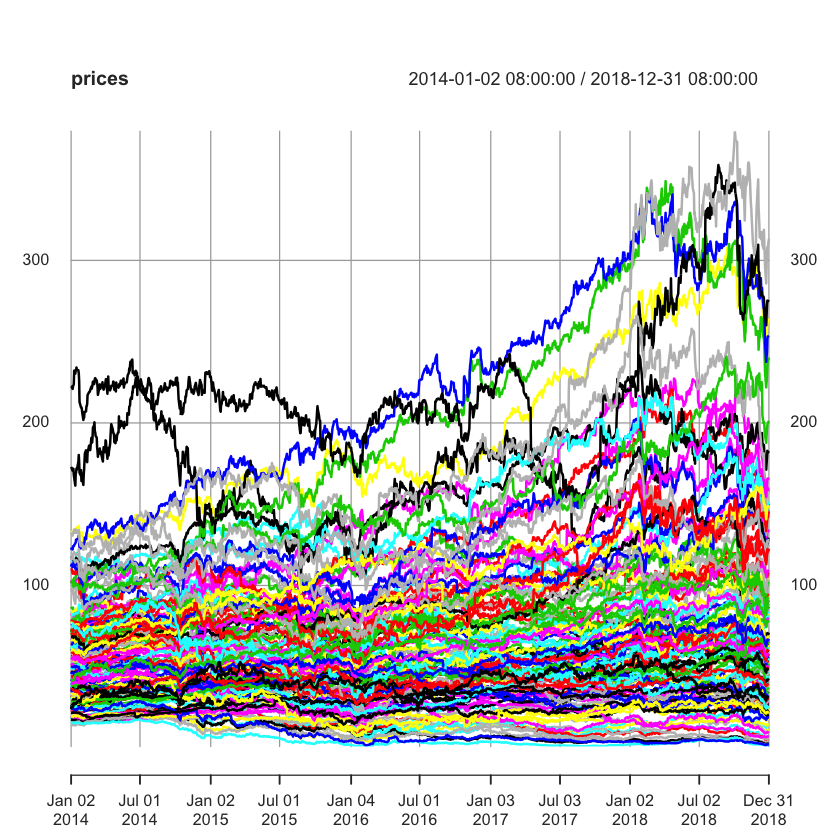

In [12]:
plot(prices)

As we can notice, stock prices are highly nonstationary!

In [13]:
#setEPS()
#pdf(file="prices.pdf", height=4, width=7.5, paper="letter", family = "Palatino")
#plot(prices, main = "Price data from a subset of S&P500 stocks")
#dev.off()

Now, let's plot the stocks log-returns.

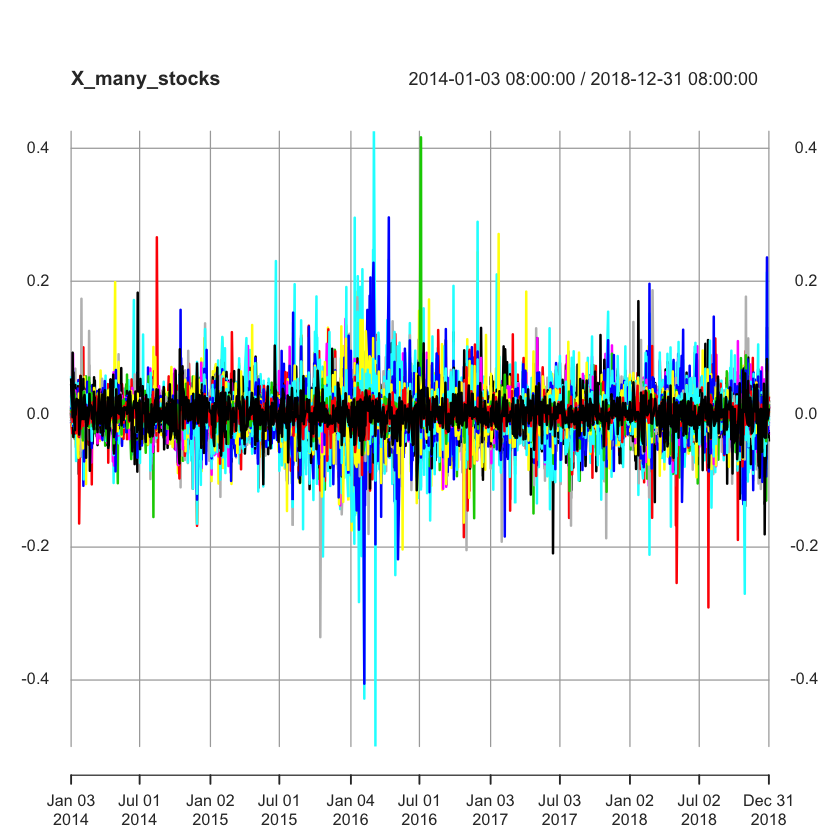

In [14]:
plot(X_many_stocks)

As we can notice, log-returns are more or less stationary.

Now, let's compute the sample correlation matrix of the log-returns time-series:

In [15]:
S <- cor(X_many_stocks)

In [16]:
dim(S)

[1] 130 130

In [17]:
head(S)

AAL       ADM       ALLE      AME       APA       APH       ATI      
AAL  1.0000000 0.2679074 0.4142058 0.3947050 0.1529924 0.4107891 0.2349170
ADM  0.2679074 1.0000000 0.3584250 0.4247647 0.3503660 0.4216412 0.3198371
ALLE 0.4142058 0.3584250 1.0000000 0.5403854 0.2737394 0.5305232 0.3060050
AME  0.3947050 0.4247647 0.5403854 1.0000000 0.4058950 0.6167725 0.4295638
APA  0.1529924 0.3503660 0.2737394 0.4058950 1.0000000 0.3444535 0.3887448
APH  0.4107891 0.4216412 0.5305232 0.6167725 0.3444535 1.0000000 0.3754039
     BA        CAG       CAT       ⋯ VLO       VRSK      WBA       WM       
AAL  0.3757651 0.1741147 0.3396871 ⋯ 0.2779788 0.3005578 0.3002158 0.2599391
ADM  0.3596224 0.3353582 0.3989959 ⋯ 0.2511981 0.2944275 0.2630513 0.3080144
ALLE 0.4443683 0.2584967 0.4454895 ⋯ 0.3345253 0.4331686 0.3807924 0.3350044
AME  0.5555758 0.2505908 0.6364150 ⋯ 0.4388306 0.4085964 0.3395665 0.3761176
APA  0.2788731 0.1508727 0.4588186 ⋯ 0.3212761 0.2243107 0.1822204 0.1692273
APH  0.5083539 0.3016491 0.5168096 ⋯ 0.3825928 0.4534389 0.3575990 0.4153803
     WMB       WMT        WPX       XEC       XOM       XYL      
AAL  0.2006771 0.20678820 0.1197429 0.1418645 0.1817828 0.3445247
ADM  0.3185182 0.25564018 0.3132372 0.3402513 0.4107965 0.3863015
ALLE 0.3419895 0.21076369 0.2407376 0.2903020 0.3853439 0.5143659
AME  0.3289986 0.28505056 0.3554465 0.4320977 0.5252260 0.6412326
APA  0.4409573 0.09685822 0.6740905 0.6934637 0.5870651 0.3625259
APH  0.2816036 0.27905128 0.2949623 0.3552392 0.4417332 0.5629102

Let's plot the sample correlation matrix:

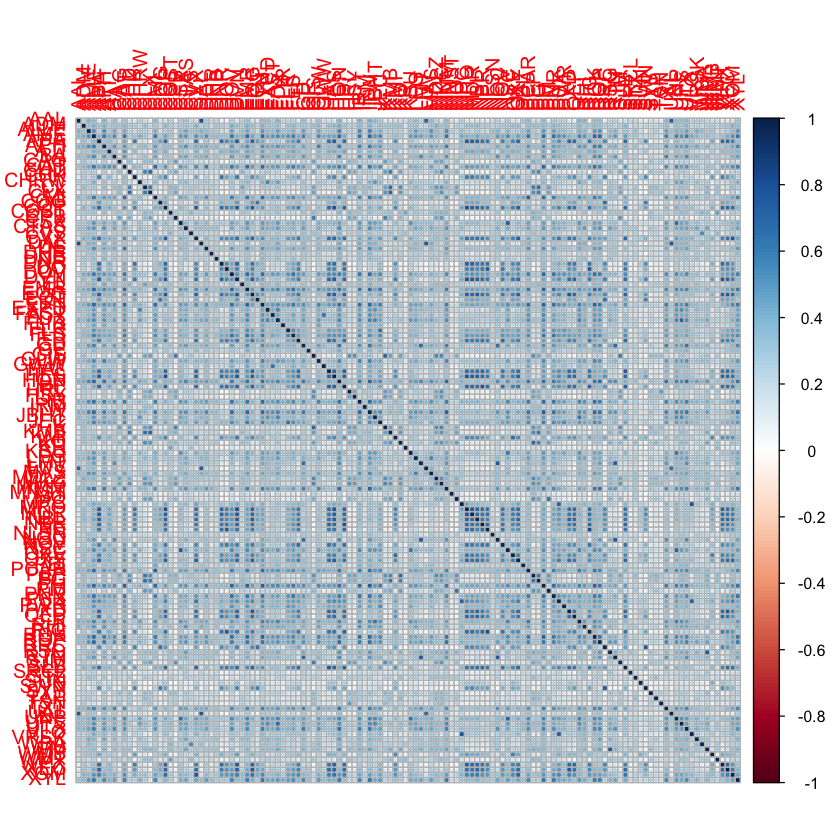

In [18]:
corrplot(S)

## Naive graph

Let's construct a naive graph based on the sample correlation matrix. For that, we will compute the [adjancency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix) assuming that the sample correlation
matrix is a model for the inverse of the Laplacian matrix:

But first let's remove the market signal which is enconded as the strongest eigenvalue of the sample correlation matrix.

In [19]:
evd_S <- eigen(S)

In [20]:
S_no_market <- evd_S$vectors %*% diag(c(0, evd_S$values[2:nrow(S)])) %*% t(evd_S$vectors)

In [21]:
L_naive <- MASS::ginv(S_no_market)
Adj_naive <- abs(diag(diag(L_naive)) - L_naive)

In [22]:
colors <- c("#6F1E51", "#1289A7", "#EE5A24")

In [23]:
mytriangle <- function(coords, v=NULL, params) {
  vertex.color <- params("vertex", "color")
  if (length(vertex.color) != 1 && !is.null(v)) {
    vertex.color <- vertex.color[v]
  }
  vertex.size <- 1/150 * params("vertex", "size")
  if (length(vertex.size) != 1 && !is.null(v)) {
    vertex.size <- vertex.size[v]
  }

  symbols(x=coords[,1], y=coords[,2], bg=vertex.color,
          stars=cbind(vertex.size, vertex.size, vertex.size),
          add=TRUE, inches=FALSE)
}
# clips as a circle
add_shape("triangle", clip=shapes("circle")$clip,
                 plot=mytriangle)

In [24]:
plot_graph_from_adjacency_matrix <- function(A_mat, edge_factor=1) {
  net <- graph_from_adjacency_matrix(A_mat, mode = "undirected", weighted = TRUE)
  la <- layout_nicely(net)
  V(net)$color <- colors[stock_sectors_index]
  V(net)$type <- stock_sectors_index
  V(net)$cluster <- stock_sectors_index
  E(net)$color <- apply(as.data.frame(get.edgelist(net)), 1,
                        function(x) ifelse(V(net)$cluster[x[1]] == V(net)$cluster[x[2]],
                                          colors[V(net)$cluster[x[1]]], 'grey'))
  plot(net, vertex.size = 4, vertex.label = NA, vertex.size = 4, vertex.label.cex = .5, layout = la,
  vertex.label.family = "Helvetica", vertex.label.color = "black", vertex.label.dist = 1,
  vertex.shape = c("square", "circle", "triangle")[V(net)$type], edge.width = edge_factor*E(net)$weight)
}

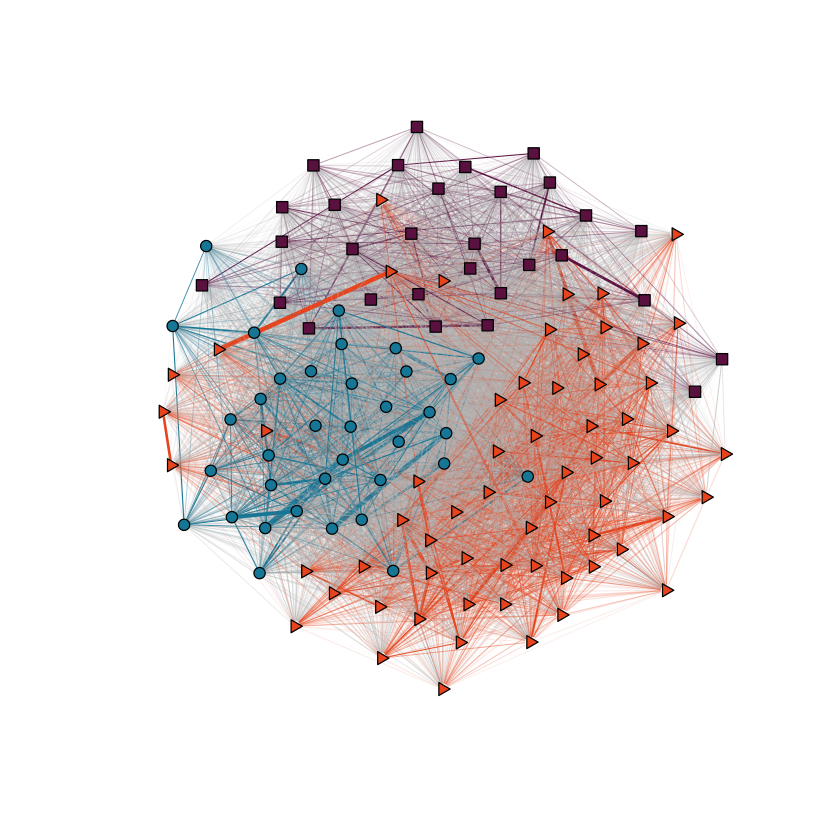

In [25]:
plot_graph_from_adjacency_matrix(Adj_naive, edge_factor = 2)

As we can see, the naive graph is not representative of our prior information that the stocks belong to three sectors.
Let's see what can be done with classical PCA.

In [26]:
gr <- .5 * (1 + sqrt(5))
setEPS()
postscript("naive_graph.ps", height = 5, width = gr * 3.5)
plot_graph_from_adjacency_matrix(Adj_naive, edge_factor = 2)
dev.off()

pdf 
  2

# PCA

Let's keep only the 2nd, 3rd, and 4th eigenvalues of the sample correlation matrix as they are assumed to represent each sector.

In [27]:
S_sectors <- evd_S$vectors %*% diag(c(0, evd_S$values[2:4], rep(0, nrow(S)-4))) %*% t(evd_S$vectors)

In [28]:
L_sectors <- MASS::ginv(S_sectors)

In [29]:
Adj_sectors <- abs(diag(diag(L_sectors)) - L_sectors)

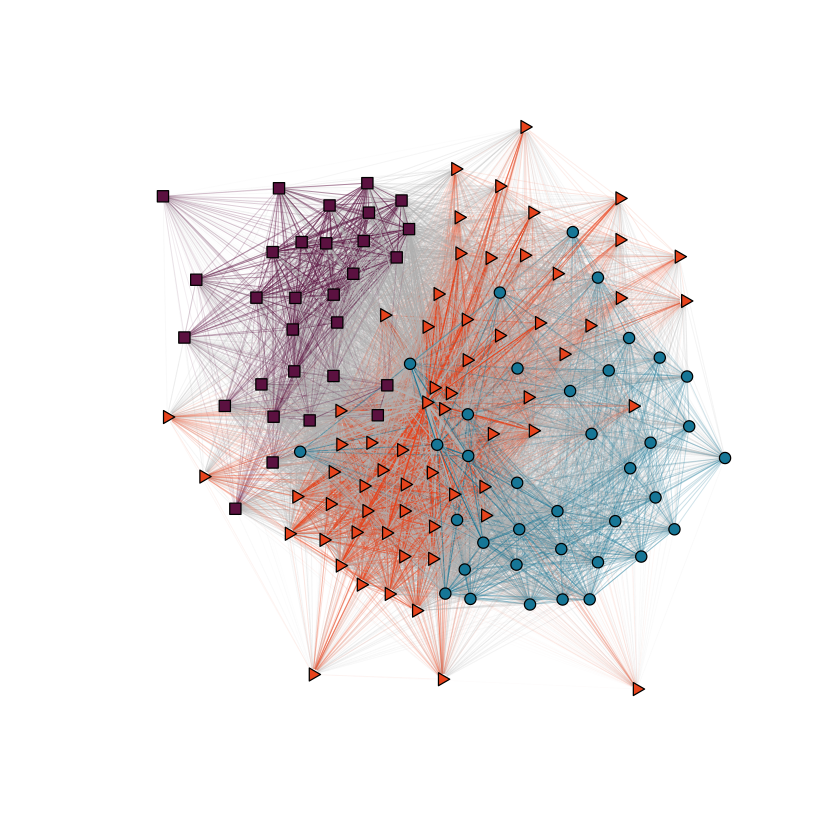

In [30]:
plot_graph_from_adjacency_matrix(Adj_sectors, edge_factor=100)

That looks a lot better than the previous plot. It's a lot easier now to see the three clusters that represent each sector.

In [31]:
setEPS()
postscript("pca_graph.ps", height = 5, width = gr * 3.5)
plot_graph_from_adjacency_matrix(Adj_sectors, edge_factor=100)
dev.off()

pdf 
  2

# Robust PCA

Now, let's use robust PCA to see what type of graph we can obtain:

In [32]:
library(rpca)

In [33]:
my_rpca <- rpca(MASS::ginv(S_no_market), lambda = 1e-1)
L_robust <- my_rpca$S

In [34]:
Adj_robust <- abs(diag(diag(L_robust)) - L_robust)

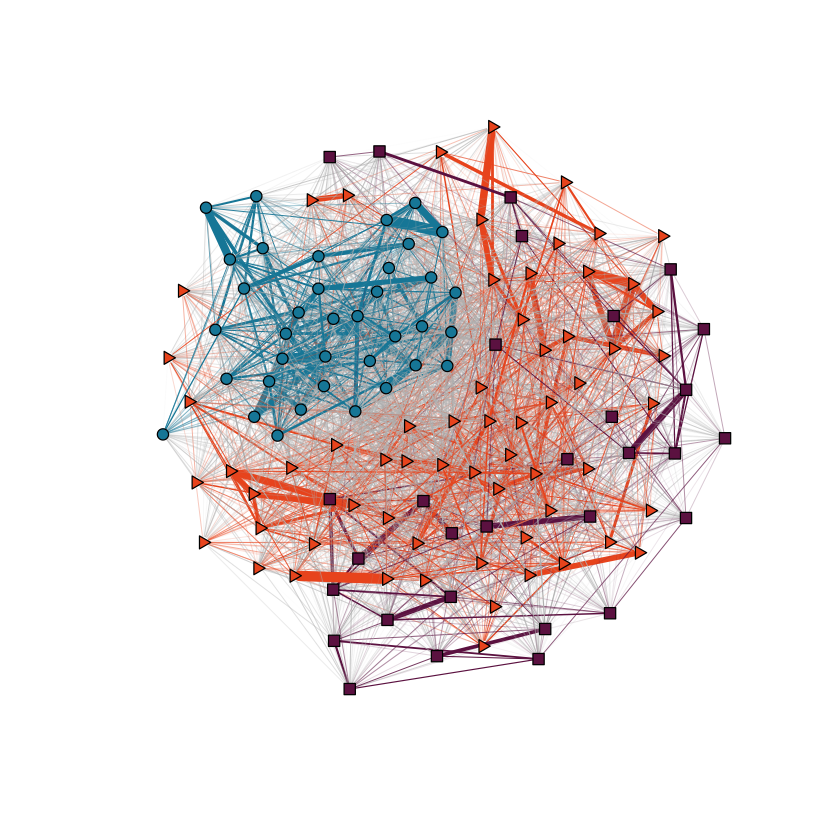

In [35]:
plot_graph_from_adjacency_matrix(Adj_robust, edge_factor=5)

That looks even better!! Here we can see that some stocks are more correlated that others (as we can notice via the thickness of the edges).

TAKEAWAY: This experiment shows that with robust PCA we are able to unveil hidden structures of the stock market!

In [36]:
setEPS()
postscript("rpca_graph.ps", height = 5, width = gr * 3.5)
plot_graph_from_adjacency_matrix(Adj_robust, edge_factor=5)
dev.off()

pdf 
  2